# Discounted Saliency Selector

In [1]:
from skimage.transform import resize
from skimage.filters import threshold_otsu
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from PIL import Image
import itertools
import os
from skimage.color import rgb2gray
from sklearn.preprocessing import StandardScaler
from math import erf, sqrt
import scipy
def load_images_from_folder(folder,RGB=True,size = 128):
    images = []
    files = os.listdir(folder)
    files.sort()
    for filename in files:
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            if RGB:
                img = resize(img,(size,size,3))
            else:
                img = rgb2gray(img)
                img = resize(img,(size,size))
            img =((img/img.max())*255).astype('uint8')
            images.append(img)
    return np.array(images)

In [2]:
from SaliencyComputations import *

In [3]:
datasets = ["Cars","dog","sky","cultivated land",'cats']
methods = ['SLIC','Spectral','PoolNet','KMeans','FineGrained']

In [4]:
ip = input(f"""Which dataset you want to chose:
1. {datasets[0]}
2. {datasets[1]}
3. {datasets[2]}
4. {datasets[3]}
5. {datasets[4]}""")

In [5]:
d = datasets[int(ip)-1]
print(f'Dataset Selected: {d}')

Dataset Selected: Cars


In [6]:
# computeSlicForDataset(d)
# computeKMeansForDataset(d)
# spectralSaliency(d)
# fineGrained(d)

In [7]:
# def Time(d):
#     time = {}
#     n = 5
#     t = timeit.timeit('computeSlicForDataset(d)',globals=globals(),number=n)
#     time['SLIC'] = t/n
#     t = timeit.timeit('spectralSaliency(d)',globals=globals(),number=n)
#     time['Spectral'] = t/n
#     poolnetTime = joblib.load('times/PoolNet_times.pkl')
#     time['PoolNet'] = poolnetTime[d]
#     t = timeit.timeit('computeKMeansForDataset(d)',globals=globals(),number=1)
#     time['KMeans'] = t/1
#     t = timeit.timeit('fineGrained(d)',globals=globals(),number=n)
#     time['FineGrained'] = t/n
#     return time
# time = Time(d)
# joblib.dump(time,f'times/t_{d}.pkl')  
time = joblib.load(f'times/t_{d}.pkl')

In [8]:
def GetSalMaps(d):
    methods = ['SLIC','Spectral','PoolNet','KMeans','FineGrained']
    SaliencyMaps = {}
    for method in methods:
        folder = f"./Saliency/{method}/saliency_{d}"
        files = os.listdir(folder)
        files.sort()
        SaliencyMaps[method] = load_images_from_folder(folder,RGB=False)
    return SaliencyMaps
SaliencyMaps = GetSalMaps(d)


In [9]:
def getDistro(bins,hist):
    D = []
    for i in range(len(hist)):
        D.extend([bins[i]]*hist[i])
    return np.array(D)
def normalise(Distr):
    return (Distr - Distr.min())/(Distr.max()-Distr.min())
def normal_dist(x , mean , sd):
    prob_density = (np.pi*sd) * np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density   

http://modelai.gettysburg.edu/2020/wgan/Resources/Lesson1/kl-divergence-gaussians.htm

In [10]:
import scipy

In [11]:
# m = SaliencyMaps['SLIC'][0]
def VisualiseSeparation(mask):
    m = mask
    t = (threshold_otsu(m))
    hist,bins = np.histogram(m.ravel(),256)
    D_bg = getDistro(bins[:t],hist[:t])
    D_fg = getDistro(bins[t:256],hist[t:])
    bg_mean = D_bg.mean()
    fg_mean = D_fg.mean()    
    bg_sd = np.std(D_bg)
    fg_sd = np.std(D_fg)
    X = np.arange(0,255)
    bg_pdf = scipy.stats.norm.pdf(X,bg_mean,bg_sd)
    fg_pdf = scipy.stats.norm.pdf(X,fg_mean,fg_sd)
    plt.figure(figsize=(10,6))
    plt.title('Normal Distribution of Background and Foreground')
    plt.plot(X,bg_pdf,label='background')
    plt.plot(X,fg_pdf,label='foreground')
    plt.legend()
    plt.show()

In [12]:
SAL_MAP = SaliencyMaps['KMeans'][0]

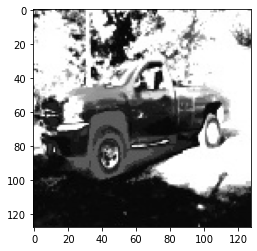

In [13]:
plt.imshow(SAL_MAP,cmap='gray')
plt.show()

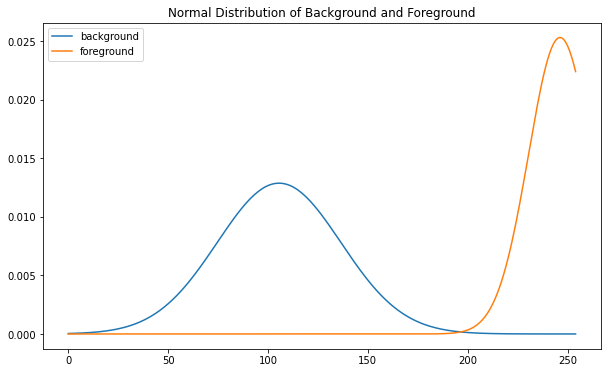

In [14]:
VisualiseSeparation(SaliencyMaps['KMeans'][0])

## Separation Analysis 
Separation analysis between the foreground distribution and background distribution of the saliency map  
using **Kullback–Leibler divergence** between the background pixel distribution and foreground distribution

In [15]:
def kld(masks):
    # """returns mean and standard deviation of background and foreground"""  
    KLD = []
    for m in masks:

        t = (threshold_otsu(m))
        hist,bins = np.histogram(m.ravel(),256)
        
        N_bg, N_fg = hist[:t].sum(),hist[t:].sum()

        pixels = hist*bins[:256]

        D_bg = (getDistro(bins[:t],hist[:t]))
        D_fg = (getDistro(bins[t:256],hist[t:]))

                
        bg_mean = D_bg.mean()
        fg_mean = D_fg.mean()
                
        bg_sd = np.std(D_bg)
        fg_sd = np.std(D_fg)

        t1 = np.log10(bg_sd/fg_sd)
        t2 = (fg_sd**2 + (fg_mean-bg_mean)**2)/(2*bg_sd**2)
        KLD.append(abs(t1 + t2 - 0.5))


    return np.array(KLD)

In [16]:
KLDs = {}
for i in SaliencyMaps:
    KLDs[i] = kld(SaliencyMaps[i])

In [17]:
pd.DataFrame.from_dict(KLDs)

,SLIC,Spectral,PoolNet,KMeans,FineGrained
0,6.522307,10.230767,320.790022,10.234650,8.733704
1,3.322864,11.103354,255.986620,10.885503,9.218537
2,8.191280,19.612068,26.155099,7.795316,11.971893
3,6.518371,25.333517,285.214259,5.426111,10.184932
4,4.274886,12.630891,49.073156,24.410881,5.025216


## connected component analysis - Concentration measure
opencv's connectedComponentsWithStats() function is being used with 4 as connected component  
parameter to obtain the salient foreground objects and their area.  
This area of each blob is then used to compute the concentration measure of the Saliency maps  


In [18]:
def getConcentration(maps):
    C = []
    for d in maps:
        binary = (d>threshold_otsu(d)).astype('uint8')
        (numLabels, labels, stats, centroids) = cv2.connectedComponentsWithStats(binary,4,cv2.CV_32S)
        areas = np.zeros(numLabels)
        for i in range(0, numLabels):
            areas[i]=stats[i, cv2.CC_STAT_AREA]
        Cu = areas/np.sum(areas)
        u = np.argmax(Cu)
        concentration = Cu[u] + ((1-Cu[u])/numLabels)
        C.append(concentration)
    return np.array(C)

Concetration measure and Separation measure are multiplied to get the final saliency score for each saliency map.  

In [19]:
CMs = {}
for i in SaliencyMaps:
    CMs[i] = getConcentration(SaliencyMaps[i])
pd.DataFrame.from_dict(CMs)

,SLIC,Spectral,PoolNet,KMeans,FineGrained
0,0.739403,0.760763,0.829926,0.538495,0.667754
1,0.600731,0.755822,0.818237,0.524425,0.607164
2,0.763617,0.906882,0.678375,0.625017,0.809369
3,0.724417,0.915131,0.739441,0.647734,0.663835
4,0.517627,0.783180,0.830017,0.608832,0.518348


In [20]:
Quality_Score = {}
for method in methods:
    Quality_Score[method] = np.sum(np.log10(KLDs[method])*CMs[method])/5

In [21]:
Sorted_Quality_Score = { i[0]:i[1] for i in sorted(Quality_Score.items(),key=lambda x:x[1],reverse=True)}
Sorted_Quality_Score

{'PoolNet': 1.6461977043406797,
 'Spectral': 0.9755658860995446,
 'FineGrained': 0.6238775849766218,
 'KMeans': 0.5931276925432089,
 'SLIC': 0.5058538830657897}

In [22]:
pd.DataFrame(Sorted_Quality_Score,index=[0]).T

,0
PoolNet,1.646198
Spectral,0.975566
FineGrained,0.623878
KMeans,0.593128
SLIC,0.505854


<BarContainer object of 5 artists>

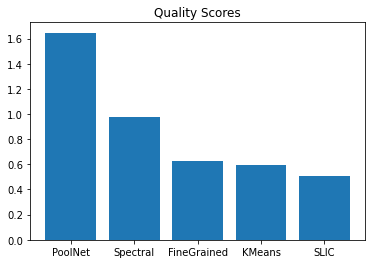

In [23]:
plt.title('Quality Scores')
plt.bar(Sorted_Quality_Score.keys(),Sorted_Quality_Score.values())

In [24]:
#use this to load precomputed time for each method


# times = {}
# for method in methods:
#     times[method] = joblib.load(f"times/{method}_times.pkl")
# time = {method:times[method][d] for method in methods}
# time

In [25]:
T_max = max(time.values())
T_min = min(time.values())
Q_max = max(Quality_Score.values())

In [26]:
def timemesure(time):
    return np.log10((T_max-time+0.5)/(time-T_min+0.5))

In [27]:
TimeScores = {}
scores = {}
for method in methods:
    Q = Quality_Score[method]
    TimeScores[method] = timemesure(time[method])
    scores[method] = Q + (Q/Q_max)*timemesure(time[method])


### time taken by each method 

In [28]:
pd.DataFrame({ i[0]:i[1] for i in sorted(time.items(),key=lambda x:x[1])},index=[0]).T

,0
FineGrained,0.527565
Spectral,0.651579
PoolNet,2.380000
SLIC,6.238214
KMeans,109.766039


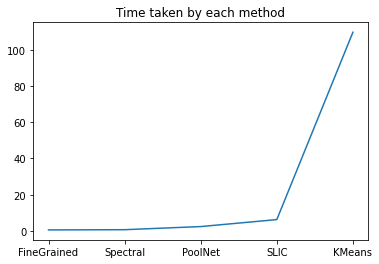

In [29]:
plt.title("Time taken by each method")
plt.plot(pd.DataFrame({ i[0]:i[1] for i in sorted(time.items(),key=lambda x:x[1])},index=[0]).T)

### time measure for each method

In [30]:
pd.DataFrame({ i[0]:i[1] for i in sorted(TimeScores.items(),key=lambda x:x[1],reverse=True)},index=[0]).T

,0
FineGrained,2.341389
Spectral,2.244674
PoolNet,1.661448
SLIC,1.224012
KMeans,-2.341389


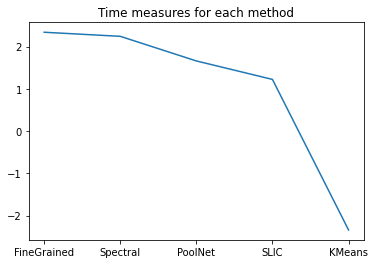

In [31]:
plt.title('Time measures for each method')
plt.plot(pd.DataFrame({ i[0]:i[1] for i in sorted(TimeScores.items(),key=lambda x:x[1],reverse=True)},index=[0]).T)

In [32]:
Sorted_Scores = { i[0]:i[1] for i in sorted(scores.items(),key=lambda x:x[1],reverse=True)}
Sorted_Scores

{'PoolNet': 3.3076452492002426,
 'Spectral': 2.305799170293861,
 'FineGrained': 1.5112194009773046,
 'SLIC': 0.881976061461873,
 'KMeans': -0.25047851562230417}

<BarContainer object of 5 artists>

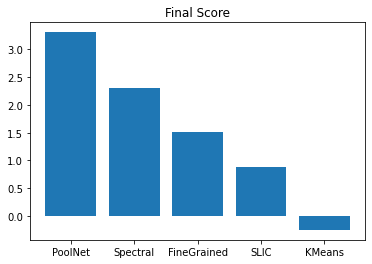

In [33]:
plt.title('Final Score')
plt.bar(Sorted_Scores.keys(),Sorted_Scores.values())

In [34]:
print(f"The best method is: {list(Sorted_Scores.keys())[0]}")

The best method is: PoolNet


In [35]:
print('Methods in order of their preferences:\n')
for i in Sorted_Scores:
    print(f'{i} with score {Sorted_Scores[i]}')

Methods in order of their preferences:

PoolNet with score 3.3076452492002426
Spectral with score 2.305799170293861
FineGrained with score 1.5112194009773046
SLIC with score 0.881976061461873
KMeans with score -0.25047851562230417
